<a href="https://colab.research.google.com/github/Arumuza/Django-_stripe/blob/master/Deforum_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deforum Stable Diffusion (v0.7.1)**
⚠️ **NOTICE: This project is no longer maintained.** ⚠️
This repository is no longer actively maintained or updated. Users are advised to find alternative solutions or fork the project if they wish to continue development.

In [1]:
#@markdown **NVIDIA GPU**
import subprocess, os, sys
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")

Tesla T4, 15360 MiB, 15101 MiB


# Setup

In [2]:
#@markdown **Environment Setup**
import subprocess, time, gc, os, sys

def setup_environment():
    try:
        ipy = get_ipython()
    except:
        ipy = 'could not get_ipython'

    if 'google.colab' in str(ipy):
        start_time = time.time()
        packages = [
            'xformers',
            'einops==0.4.1 pytorch-lightning==2.3.3 torchdiffeq==0.2.3 torchsde==0.2.6',
            'ftfy timm transformers open-clip-torch==2.24.0 omegaconf torchmetrics==0.11.4',
            'safetensors kornia accelerate jsonmerge matplotlib resize-right',
            'scikit-learn numpngw pydantic scikit-image==0.19.3'
        ]
        for package in packages:
            print(f"..installing {package}")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + package.split())
        if not os.path.exists("deforum-stable-diffusion"):
            subprocess.check_call(['git', 'clone', 'https://github.com/deforum-art/deforum-stable-diffusion.git'])
        else:
            print(f"..deforum-stable-diffusion already exists")
        with open('deforum-stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
            f.write('')
        sys.path.extend(['deforum-stable-diffusion/','deforum-stable-diffusion/src',])
        end_time = time.time()
        print(f"..environment set up in {end_time-start_time:.0f} seconds")
    else:
        sys.path.extend(['src'])
        print("..skipping setup")

setup_environment()

import torch
import random
import clip
from IPython import display
from types import SimpleNamespace
from helpers.save_images import get_output_folder
from helpers.settings import load_args
from helpers.render import render_animation, render_input_video, render_image_batch, render_interpolation
from helpers.model_load import make_linear_decode, load_model, get_model_output_paths
from helpers.aesthetics import load_aesthetics_model
from helpers.prompts import Prompts

..installing xformers
..installing einops==0.4.1 pytorch-lightning==2.3.3 torchdiffeq==0.2.3 torchsde==0.2.6
..installing ftfy timm transformers open-clip-torch==2.24.0 omegaconf torchmetrics==0.11.4
..installing safetensors kornia accelerate jsonmerge matplotlib resize-right
..installing scikit-learn numpngw pydantic scikit-image==0.19.3
..environment set up in 37 seconds


In [3]:
#@markdown **Path Setup**

def PathSetup():
    models_path = "models" #@param {type:"string"}
    configs_path = "configs" #@param {type:"string"}
    output_path = "outputs" #@param {type:"string"}
    mount_google_drive = True #@param {type:"boolean"}
    models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
    output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
    return locals()

root = SimpleNamespace(**PathSetup())
root.models_path, root.output_path = get_model_output_paths(root)

Mounted at /content/drive
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/StableDiffusion


In [4]:
#@markdown **Model Setup**

def ModelSetup():
    map_location = "cuda" #@param ["cpu", "cuda"]
    model_config = "v1-inference.yaml" #@param ["custom","v2-inference.yaml","v2-inference-v.yaml","v1-inference.yaml"]
    model_checkpoint =  "Protogen_V2.2.ckpt" #@param ["custom","v2-1_768-ema-pruned.ckpt","v2-1_512-ema-pruned.ckpt","768-v-ema.ckpt","512-base-ema.ckpt","Protogen_V2.2.ckpt","v1-5-pruned.ckpt","v1-5-pruned-emaonly.ckpt","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","wd-v1-3-float16.ckpt"]
    custom_config_path = "" #@param {type:"string"}
    custom_checkpoint_path = "" #@param {type:"string"}
    return locals()

root.__dict__.update(ModelSetup())
root.model, root.device = load_model(root, load_on_run_all=True, check_sha256=True, map_location=root.map_location)

..attempting to download Protogen_V2.2.ckpt...this may take a while


Protogen_V2.2.ckpt: 100%|██████████| 4.27G/4.27G [01:13<00:00, 57.7MB/s]


config_path: /content/deforum-stable-diffusion/configs/v1-inference.yaml
ckpt_path: /content/drive/MyDrive/AI/models/Protogen_V2.2.ckpt
..checking sha256
..hash is correct
..loading model


/content/deforum-stable-diffusion/helpers/model_load.py:230: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pl_sd = torch.load(ckpt, map_location=map_location)
/usr/local/lib

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

# Settings

In [5]:
def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = 'None' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 1000 #@param {type:"number"}
    border = 'replicate' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0:(1.04)"#@param {type:"string"}
    translation_x = "0:(10*sin(2*3.14*t/10))"#@param {type:"string"}
    translation_y = "0:(0)"#@param {type:"string"}
    translation_z = "0:(10)"#@param {type:"string"}
    rotation_3d_x = "0:(0)"#@param {type:"string"}
    rotation_3d_y = "0:(0)"#@param {type:"string"}
    rotation_3d_z = "0:(0)"#@param {type:"string"}
    flip_2d_perspective = False #@param {type:"boolean"}
    perspective_flip_theta = "0:(0)"#@param {type:"string"}
    perspective_flip_phi = "0:(t%15)"#@param {type:"string"}
    perspective_flip_gamma = "0:(0)"#@param {type:"string"}
    perspective_flip_fv = "0:(53)"#@param {type:"string"}
    noise_schedule = "0: (0.02)"#@param {type:"string"}
    strength_schedule = "0: (0.65)"#@param {type:"string"}
    contrast_schedule = "0: (1.0)"#@param {type:"string"}
    hybrid_comp_alpha_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_blend_alpha_schedule = "0:(0.5)" #@param {type:"string"}
    hybrid_comp_mask_contrast_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_high_schedule =  "0:(100)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_low_schedule =  "0:(0)" #@param {type:"string"}

    #@markdown ####**Sampler Scheduling:**
    enable_schedule_samplers = False #@param {type:"boolean"}
    sampler_schedule = "0:('euler'),10:('dpm2'),20:('dpm2_ancestral'),30:('heun'),40:('euler'),50:('euler_ancestral'),60:('dpm_fast'),70:('dpm_adaptive'),80:('dpmpp_2s_a'),90:('dpmpp_2m')" #@param {type:"string"}

    #@markdown ####**Unsharp mask (anti-blur) Parameters:**
    kernel_schedule = "0: (5)"#@param {type:"string"}
    sigma_schedule = "0: (1.0)"#@param {type:"string"}
    amount_schedule = "0: (0.2)"#@param {type:"string"}
    threshold_schedule = "0: (0.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 LAB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB', 'Video Input'] {type:'string'}
    color_coherence_video_every_N_frames = 1 #@param {type:"integer"}
    color_force_grayscale = False #@param {type:"boolean"}
    diffusion_cadence = '1' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 40#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}
    overwrite_extracted_frames = True #@param {type:"boolean"}
    use_mask_video = False #@param {type:"boolean"}
    video_mask_path ='/content/video_in.mp4'#@param {type:"string"}

    #@markdown ####**Hybrid Video for 2D/3D Animation Mode:**
    hybrid_generate_inputframes = False #@param {type:"boolean"}
    hybrid_use_first_frame_as_init_image = True #@param {type:"boolean"}
    hybrid_motion = "None" #@param ['None','Optical Flow','Perspective','Affine']
    hybrid_motion_use_prev_img = False #@param {type:"boolean"}
    hybrid_flow_method = "DIS Medium" #@param ['DenseRLOF','DIS Medium','Farneback','SF']
    hybrid_composite = False #@param {type:"boolean"}
    hybrid_comp_mask_type = "None" #@param ['None', 'Depth', 'Video Depth', 'Blend', 'Difference']
    hybrid_comp_mask_inverse = False #@param {type:"boolean"}
    hybrid_comp_mask_equalize = "None" #@param  ['None','Before','After','Both']
    hybrid_comp_mask_auto_contrast = False #@param {type:"boolean"}
    hybrid_comp_save_extra_frames = False #@param {type:"boolean"}
    hybrid_use_video_as_mse_image = False #@param {type:"boolean"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 20 #@param {type:"number"}

    #@markdown ####**Resume Animation:**
    resume_from_timestring = False #@param {type:"boolean"}
    resume_timestring = "20220829210106" #@param {type:"string"}

    return locals()

In [9]:
# prompts
prompts = {
    0: "a beautiful lake by Asher Brown Durand, trending on Artstation",
    10: "a beautiful portrait of a woman by Artgerm, trending on Artstation",
}

neg_prompts = {
    0: "mountain",
}

# can be a string, list, or dictionary
#prompts = [
#    "a beautiful lake by Asher Brown Durand, trending on Artstation",
#    "a beautiful portrait of a woman by Artgerm, trending on Artstation",
#]
#prompts = "a beautiful lake by Asher Brown Durand, trending on Artstation"

INFO:lightning_fabric.utilities.seed:Seed set to 1073876249


Saving to /content/drive/MyDrive/AI/StableDiffusion/2024-10/StableFun/20241015015643_*
Prompt 1 of 2
cond_prompt: a beautiful lake by Asher Brown Durand, trending on Artstation
uncond_prompt: mountain
Batch 1 of 1
tenc: 50


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


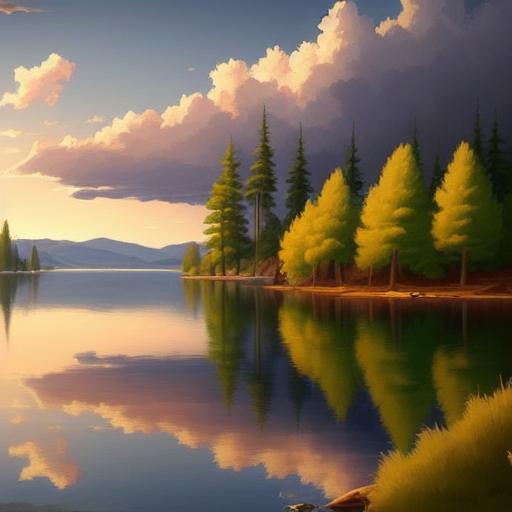

INFO:lightning_fabric.utilities.seed:Seed set to 1073876250


Prompt 2 of 2
cond_prompt: a beautiful portrait of a woman by Artgerm, trending on Artstation
uncond_prompt: mountain
Batch 1 of 1
tenc: 50


100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


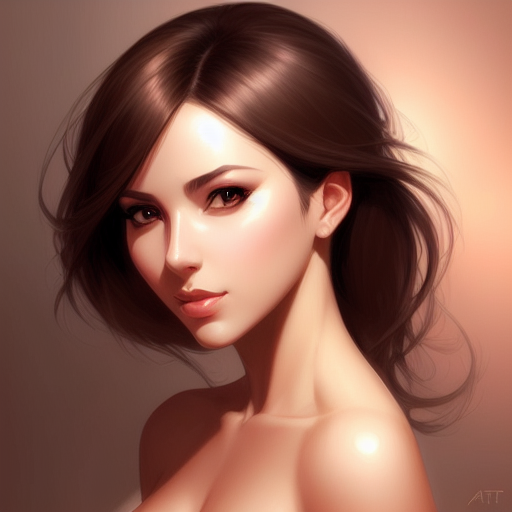

In [10]:
#@markdown **Load Settings**
override_settings_with_file = False #@param {type:"boolean"}
settings_file = "custom" #@param ["custom", "512x512_aesthetic_0.json","512x512_aesthetic_1.json","512x512_colormatch_0.json","512x512_colormatch_1.json","512x512_colormatch_2.json","512x512_colormatch_3.json"]
custom_settings_file = "/content/drive/MyDrive/Settings.txt"#@param {type:"string"}

def DeforumArgs():
    #@markdown **Image Settings**
    W = 512 #@param
    H = 512 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64
    bit_depth_output = 8 #@param [8, 16, 32] {type:"raw"}

    #@markdown **Sampling Settings**
    seed = -1 #@param
    sampler = 'euler_ancestral' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim", "dpm_fast", "dpm_adaptive", "dpmpp_2s_a", "dpmpp_2m"]
    steps = 50 #@param
    scale = 7 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}
    save_sample_per_step = False #@param {type:"boolean"}
    show_sample_per_step = False #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    n_samples = 1 #@param
    batch_name = "StableFun" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random","ladder","alternate"]
    seed_iter_N = 1 #@param {type:'integer'}
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param
    outdir = get_output_folder(root.output_path, batch_name)

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.65 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    add_init_noise = False #@param {type:"boolean"}
    init_noise = 0.01 #@param
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}
    # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
    overlay_mask = True  # {type:"boolean"}
    # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
    mask_overlay_blur = 5 # {type:"number"}

    #@markdown **Exposure/Contrast Conditional Settings**
    mean_scale = 0 #@param {type:"number"}
    var_scale = 0 #@param {type:"number"}
    exposure_scale = 0 #@param {type:"number"}
    exposure_target = 0.5 #@param {type:"number"}

    #@markdown **Color Match Conditional Settings**
    colormatch_scale = 0 #@param {type:"number"}
    colormatch_image = "https://www.saasdesign.io/wp-content/uploads/2021/02/palette-3-min-980x588.png" #@param {type:"string"}
    colormatch_n_colors = 4 #@param {type:"number"}
    ignore_sat_weight = 0 #@param {type:"number"}

    #@markdown **CLIP\Aesthetics Conditional Settings**
    clip_name = 'ViT-L/14' #@param ['ViT-L/14', 'ViT-L/14@336px', 'ViT-B/16', 'ViT-B/32']
    clip_scale = 0 #@param {type:"number"}
    aesthetics_scale = 0 #@param {type:"number"}
    cutn = 1 #@param {type:"number"}
    cut_pow = 0.0001 #@param {type:"number"}

    #@markdown **Other Conditional Settings**
    init_mse_scale = 0 #@param {type:"number"}
    init_mse_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    blue_scale = 0 #@param {type:"number"}

    #@markdown **Conditional Gradient Settings**
    gradient_wrt = 'x0_pred' #@param ["x", "x0_pred"]
    gradient_add_to = 'both' #@param ["cond", "uncond", "both"]
    decode_method = 'linear' #@param ["autoencoder","linear"]
    grad_threshold_type = 'dynamic' #@param ["dynamic", "static", "mean", "schedule"]
    clamp_grad_threshold = 0.2 #@param {type:"number"}
    clamp_start = 0.2 #@param
    clamp_stop = 0.01 #@param
    grad_inject_timing = list(range(1,10)) #@param

    #@markdown **Speed vs VRAM Settings**
    cond_uncond_sync = True #@param {type:"boolean"}
    precision = 'autocast'
    C = 4
    f = 8

    cond_prompt = ""
    cond_prompts = ""
    uncond_prompt = ""
    uncond_prompts = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_sample_raw = None
    mask_sample = None
    init_c = None
    seed_internal = 0

    return locals()

args_dict = DeforumArgs()
anim_args_dict = DeforumAnimArgs()

if override_settings_with_file:
    load_args(args_dict, anim_args_dict, settings_file, custom_settings_file, verbose=False)

args = SimpleNamespace(**args_dict)
anim_args = SimpleNamespace(**anim_args_dict)

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

# Load clip model if using clip guidance
if (args.clip_scale > 0) or (args.aesthetics_scale > 0):
    root.clip_model = clip.load(args.clip_name, jit=False)[0].eval().requires_grad_(False).to(root.device)
    if (args.aesthetics_scale > 0):
        root.aesthetics_model = load_aesthetics_model(args, root)

if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

# get prompts
cond, uncond = Prompts(prompt=prompts,neg_prompt=neg_prompts).as_dict()

# dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(root, anim_args, args, cond, uncond)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(root, anim_args, args, cond, uncond)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(root, anim_args, args, cond, uncond)
else:
    render_image_batch(root, args, cond, uncond)

# Create Video From Frames

In [13]:
#@markdown **New Version**
skip_video_for_run_all = True #@param {type: 'boolean'}
create_gif = False #@param {type: 'boolean'}

if skip_video_for_run_all == True:
    print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
else:

    from helpers.ffmpeg_helpers import get_extension_maxframes, get_auto_outdir_timestring, get_ffmpeg_path, make_mp4_ffmpeg, make_gif_ffmpeg, patrol_cycle

    def ffmpegArgs():
        ffmpeg_mode = "auto" #@param ["auto","manual","timestring"]
        ffmpeg_outdir = "" #@param {type:"string"}
        ffmpeg_timestring = "" #@param {type:"string"}
        ffmpeg_image_path = "" #@param {type:"string"}
        ffmpeg_mp4_path = "" #@param {type:"string"}
        ffmpeg_gif_path = "" #@param {type:"string"}
        ffmpeg_extension = "png" #@param {type:"string"}
        ffmpeg_maxframes = 200 #@param
        ffmpeg_fps = 12 #@param

        # determine auto paths
        if ffmpeg_mode == 'auto':
            ffmpeg_outdir, ffmpeg_timestring = get_auto_outdir_timestring(args,ffmpeg_mode)
        if ffmpeg_mode in ["auto","timestring"]:
            ffmpeg_extension, ffmpeg_maxframes = get_extension_maxframes(args,ffmpeg_outdir,ffmpeg_timestring)
            ffmpeg_image_path, ffmpeg_mp4_path, ffmpeg_gif_path = get_ffmpeg_path(ffmpeg_outdir, ffmpeg_timestring, ffmpeg_extension)
        return locals()

    ffmpeg_args_dict = ffmpegArgs()
    ffmpeg_args = SimpleNamespace(**ffmpeg_args_dict)
    make_mp4_ffmpeg(ffmpeg_args, display_ffmpeg=True, debug=False)
    if create_gif:
        make_gif_ffmpeg(ffmpeg_args, debug=False)
    #patrol_cycle(args,ffmpeg_args)

Skipping video creation, uncheck skip_video_for_run_all if you want to run it


# Disconnect Runtime

In [ ]:
skip_disconnect_for_run_all = True #@param {type: 'boolean'}

if skip_disconnect_for_run_all == True:
    print('Skipping disconnect, uncheck skip_disconnect_for_run_all if you want to run it')
else:
    from google.colab import runtime
    runtime.unassign()